# Calculating calibration densities and plotting models at UCB
- This workbook shows how we calculate densities for calibration data, plot models and calculate the cali lines

In [1]:
# Import useful python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
import os
import DiadFit as pf
import datetime

## Downloading DiadFit locally
- The easiest way to install diad fit is by removing the #. It will install from PyPI
- You only need to do this once on each computer, or run in order to grab an updated version. 

### This imports DiadFit, and gives you the version. In all communication with Penny, make sure you say the version!


In [2]:
import DiadFit as pf
pf.__version__

'0.0.82'

## Plot of density vs fermi splitting

In [3]:
input_file_path=os.getcwd()+'\Input_files'

cornellpath=input_file_path+'/'+"1-s2.0-S0009254121004654-mmc1.xlsx"

###################### Ones in final UC Berkeley cali ##############################

# This data was collected on June 1st and 2nd by Penny Wieser, using the new low P sensor, 
# densities ranging from 0.009 to 0.68 g/cm3 (because sensor tops out at 10 MPa)
## This is one half of the final calibration data.
# Spectra and metadata folder 'June_2023_cali_lowdensity' and 'June2023_Cali_Supcritical' - June 1st
PW_data_path=input_file_path+'/'+"merged_df_wrho_PWdata.xlsx"

# Charlotte collected this data on June 7th, 0.56 g/cm3 to 1.05 g/cm3. We do use this. See UCB_6-7-23. 
HPjune_data_path=input_file_path+'/'+"merged_df_wrho-6-7-23.xlsx"

# Charlotte collected this data on June 8th, 0.22-0.66 g/cm3. Its the new high pressure sensor, 
# so shows less extreme curves, but still some curve. 
MPjune_HPsens_data_path=input_file_path+'/'+"merged_df_wrho-6-8-23.xlsx"


################## Poorly behaved ones ############################################3
# This is the poorly behaved one with the old sensor - we dont use this in the final cali
April_data_path=input_file_path+'/'+"merged_df_wrho-4-10-23.xlsx"





cornellcell=pd.read_excel(cornellpath)
display(cornellcell.head())

,Date,time,Date group,Raw file name,Sample type,v- position (cm-1),v+ position (cm-1),∆CO2 (cm-1),Ne corrected ∆CO2 (cm-1),P(Median-MPa),...,WANG vs EOS,LAM vs EOS,Neon data,1122 peak position (cm-1),1453 peak position (cm-1),∆Ne-m (cm-1),∆Ne-r (cm-1),1122 r (cm-1),1453 r (cm-1),"Comments (power-mW, integrationxaccumulations, associated Ne)"
0,11/29/2020,1900-01-01 01:20:58,NOV_2020,POC58,FDCA,1286.7182,1389.4400,102.7218,102.7817,0.037,...,0.020605,0.047001,NaN,1123.4561,1453.7410,330.2849,330.477634,1122.776289,1453.253923,56.590X5NE77
1,11/29/2020,1900-01-01 01:10:45,NOV_2020,POC57,FDCA,1286.7205,1389.4383,102.7178,102.7844,0.040,...,0.021512,0.047899,NaN,1123.4697,1453.7333,330.2636,330.477634,1122.776289,1453.253923,56.590X5NE76
2,11/29/2020,1900-01-01 00:54:26,NOV_2020,POC55,FDCA,1286.7079,1389.4321,102.7242,102.7868,0.061,...,0.022023,0.048400,NaN,1123.4566,1453.7330,330.2764,330.477634,1122.776289,1453.253923,56.590X3NE74
3,11/29/2020,1900-01-01 00:46:57,NOV_2020,POC54,FDCA,1286.6881,1389.4193,102.7312,102.7939,0.070,...,0.024418,0.050759,NaN,1123.4597,1453.7359,330.2762,330.477634,1122.776289,1453.253923,56.590X3NE72
4,09/18/2020,9:58:56 PM,SEPT_2020,CUC31,FDCA,1286.0110,1388.7926,102.7816,102.8011,0.083,...,0.026791,0.053084,NaN,1122.6997,1453.1146,330.4149,330.477600,1122.776300,1453.253900,Ne41


In [4]:
april_data=pd.read_excel(April_data_path)
april_data=april_data.drop(columns=[col for col in april_data.columns if 'Unnamed' in col])
april_data.head()



,Label,P_kbar,T_K,CO2_dens_gcm3,P_Mpa_target,P_manual,T0_manual,T1_manual,T2_manual,T3_manual,...,median_pressure,mad_pressure,median_temp,mad_temp,filename_nocrr,filename_merge,filename_split,T_C_mean,T_C_std,rho_gmL
0,FDCA-P1-1,0.648713,310.15,1.040000,64.871318,62.4879,37.002,37.006,37.011,37.012,...,62.489000,0.000706,31.603516,0.002679,003 FDCA-P1-1,FDCA-P1-1,FDCA-P1,37.0086,0.004450,1.034183
1,FDCA-P1-2,NaN,NaN,NaN,NaN,62.4730,37.016,37.014,37.012,37.013,...,62.473144,0.001202,31.611328,0.002685,005 FDCA-P1-2,FDCA-P1-2,FDCA-P1,37.0138,0.001483,1.034131
2,FDCA-P1-3,NaN,NaN,NaN,NaN,62.4508,36.997,37.001,37.004,37.005,...,62.452215,0.001161,31.642578,0.003603,007 FDCA-P1-3,FDCA-P1-3,FDCA-P1,37.0024,0.003435,1.034108
3,FDCA-P2-1,0.592398,310.15,1.025959,59.239802,59.2656,36.989,36.989,36.988,36.987,...,59.265227,0.001133,31.650391,0.004547,009 FDCA-P2-1,FDCA-P2-1,FDCA-P2,36.9882,0.000837,1.026057
4,FDCA-P2-2,NaN,NaN,NaN,NaN,59.2523,37.001,37.003,37.005,37.007,...,59.250048,0.001667,31.667969,0.003524,011 FDCA-P2-2,FDCA-P2-2,FDCA-P2,37.0060,0.005000,1.025970


In [5]:
hpjune=pd.read_excel(HPjune_data_path)
hpjune=hpjune.drop(columns=[col for col in hpjune.columns if 'Unnamed' in col])
hpjune.head()



,Label,P_kbar,T_K,CO2_dens_gcm3,P_Mpa_target,P_manual,T0_manual,T1_manual,T2_manual,T3_manual,...,filename_nocrr,filename_split,T_C_mean,T_C_std,rho_gmL,1117_1447_old,1117_1447_new,1220_1447_new,1220_1400_new,1117_1400_new
0,FDCA-P1-1,0.648713,310.15,1.040000,64.871318,66.4600,36.970,36.970,36.970,36.970,...,FDCA-P1-1,FDCA-P1,36.9700,0.000000,1.043839,0.997595,0.997595,0.997263,1.002603,0.997336
1,FDCA-P1-2,NaN,NaN,NaN,NaN,66.4600,36.970,36.970,36.970,36.970,...,FDCA-P1-2,FDCA-P1,36.9700,0.000000,1.043831,0.997594,0.997594,0.997262,1.002602,0.997335
2,FDCA-P1-3,NaN,NaN,NaN,NaN,66.4600,36.970,36.970,36.970,36.970,...,FDCA-P1-3,FDCA-P1,36.9700,0.000000,1.043820,0.997594,0.997594,0.997262,1.002602,0.997335
3,FDCA-P2-1,0.592398,310.15,1.025959,59.239802,60.1811,36.974,36.975,36.976,36.976,...,FDCA-P2-1,FDCA-P2,36.9754,0.000894,1.028451,0.997588,0.997588,0.997256,1.002594,0.997327
4,FDCA-P2-2,NaN,NaN,NaN,NaN,60.1815,36.976,36.977,36.978,36.979,...,FDCA-P2-2,FDCA-P2,36.9778,0.001304,1.028444,0.997587,0.997587,0.997256,1.002594,0.997326


In [6]:

lpmpjune=pd.read_excel(PW_data_path)
lpmpjune=lpmpjune.drop(columns=[col for col in lpmpjune.columns if 'Unnamed' in col])
lpmpjune['Corr_Split_1σ_val']=lpmpjune['Corr_Split+1σ']-lpmpjune['Corrected_Splitting']
lpmpjune.head()


,Corrected_Splitting,Corr_Split+1σ,Corr_Split-1σ,filename_x,Splitting,Split_err_abs,Split_err_quadrature,Diad1_Combofit_Cent,Diad1_cent_err,Diad1_Combofit_Height,...,ThermistorT_Std,AvP_Manuel,rho_gmL,filename_x.1,Ne_corr_fact_old_1447_1117,Ne_corr_fact_1447_1117_V77,1220_1447_new,1220_1400_new,1117_1400_new,Corr_Split_1σ_val
0,104.317427,104.319067,104.315787,12 C6_CRR_DiadFit,104.569330,0.002040,0.001474,1282.899792,0.001234,8503.996689,...,0.000707,10.09850,0.687860,12 C6_CRR_DiadFit,0.997591,0.997592,0.997239,1.002552,0.997290,0.001640
1,104.253899,104.255586,104.252212,14 C7_CRR_DiadFit,104.506344,0.002089,0.001527,1283.055183,0.001320,4159.640332,...,0.003031,9.45820,0.652035,14 C7_CRR_DiadFit,0.997584,0.997585,0.997233,1.002546,0.997285,0.001687
2,104.191284,104.193021,104.189548,16 C8,104.444319,0.002222,0.001583,1283.206389,0.001248,2439.022384,...,0.003391,9.09595,0.621071,16 C8,0.997577,0.997578,0.997228,1.002543,0.997282,0.001736
3,104.187881,104.189711,104.186050,17 C9,104.441140,0.002336,0.001687,1283.204984,0.001410,2470.540943,...,0.003419,9.10230,0.621495,17 C9,0.997575,0.997576,0.997226,1.002540,0.997280,0.001831
4,104.039708,104.041630,104.037786,19 C10,104.293657,0.002524,0.001787,1283.523492,0.001324,2413.101156,...,0.004146,8.63880,0.548014,19 C10,0.997565,0.997566,0.997218,1.002530,0.997271,0.001922


Text(0, 0.5, 'Density gcm3')

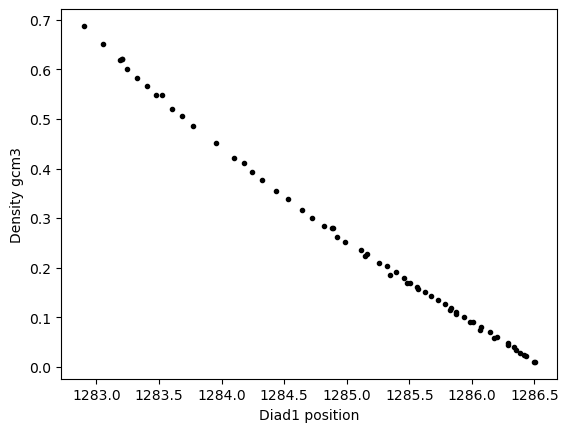

In [7]:
plt.plot(lpmpjune['Diad1_Combofit_Cent'], lpmpjune['rho_gmL'], '.k')
plt.xlabel('Diad1 position')
plt.ylabel('Density gcm3')

Text(0, 0.5, 'Density gcm3')

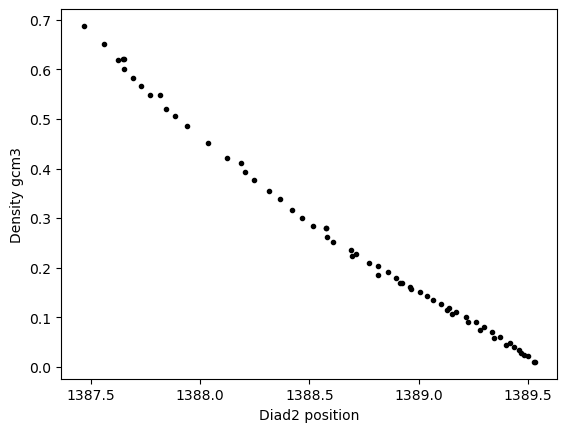

In [8]:
plt.plot(lpmpjune['Diad2_Combofit_Cent'], lpmpjune['rho_gmL'], '.k')
plt.xlabel('Diad2 position')
plt.ylabel('Density gcm3')

[]

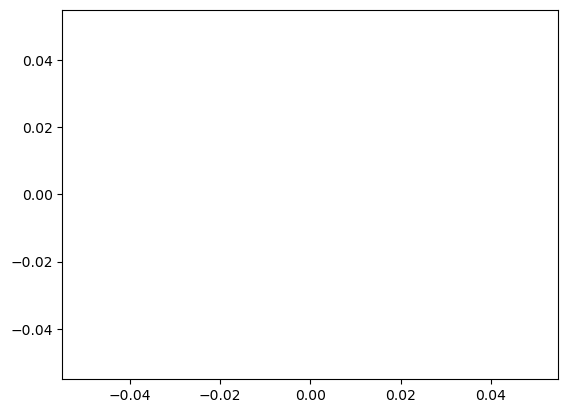

In [9]:
plt.plot()

In [10]:
mpjune_hpsens=pd.read_excel(MPjune_HPsens_data_path)
mpjune_hpsens=mpjune_hpsens.drop(columns=[col for col in mpjune_hpsens.columns if 'Unnamed' in col])
mpjune_hpsens.head()

,Label,P_kbar,T_K,CO2_dens_gcm3,P_Mpa_target,P_manual,T0_manual,T1_manual,T2_manual,T3_manual,...,filename_merge,filename_split,T_C_mean,T_C_std,rho_gmL,1117_1447_old,1117_1447_new,1220_1447_new,1220_1400_new,1117_1400_new
0,FDCA-P28-1,0.095909,310.15,0.660905,9.590924,9.6752,36.975,36.976,36.976,36.976,...,FDCA-P28-1,58 FDCA-P28,36.9756,0.000548,0.666442,0.997535,0.997535,0.997188,1.002531,0.997279
1,FDCA-P29-1,0.093876,310.15,0.646865,9.387566,9.4594,37.002,37.003,37.003,37.003,...,FDCA-P29-1,56 FDCA-P29,37.0028,0.000447,0.635696,0.997536,0.997536,0.997192,1.002530,0.997279
2,FDCA-P30-1,0.092172,310.15,0.632824,9.217169,9.2497,36.978,36.980,36.981,36.982,...,FDCA-P30-1,55 FDCA-P30,36.9808,0.001924,0.636492,0.997536,0.997536,0.997192,1.002530,0.997279
3,FDCA-P31-1,0.090746,310.15,0.618784,9.074609,9.0269,36.995,36.994,36.993,36.993,...,FDCA-P31-1,53 FDCA-P31,36.9932,0.001483,0.613721,0.997537,0.997537,0.997196,1.002531,0.997280
4,FDCA-P32-1,0.089553,310.15,0.604743,8.955350,8.9823,37.015,37.015,37.015,37.016,...,FDCA-P32-1,52 FDCA-P32,37.0156,0.000894,0.607595,0.997537,0.997538,0.997197,1.002531,0.997280


In [11]:
# # This is to calculate the prediction of the cornell densimeter on our april data
# rho_cornell=pf.calculate_density_cornell(temp='SupCrit', corrected_split=april_data['Corrected_Splitting'])
# april_data['cornellEQ_predrho']=rho_cornell['Preferred D']
# april_data.head()

In [12]:
# fig,ax=plt.subplots()

# x='Corrected_Splitting'
# y='rho_gmL'
# y_pw='rho_gmL'
# ax.errorbar(x=april_data[x],y=april_data[y], fmt='.',xerr=april_data['Corr_Split_1σ_val'],
#              color='orange',mfc='orange', ecolor='black', capsize=1,elinewidth=1,barsabove=True,zorder=2,
#            label='UCB April CD w hP sensor')

# ax.errorbar(x=mpjune_hpsens[x],y=mpjune_hpsens[y], xerr=mpjune_hpsens['Corr_Split_1σ_val'], fmt='.',
#              color='blue',mfc='blue', ecolor='black', elinewidth=1,capsize=1,barsabove=True,zorder=2,
#            label='UCB June medP w hP sensor')

# ax.errorbar(x=hpjune[x],y=hpjune[y], xerr=hpjune['Corr_Split_1σ_val'], fmt='.',
#              color='blue',mfc='blue', ecolor='black', elinewidth=1,capsize=1,barsabove=True,zorder=2,
#            label='UCB June CD highP w hP sensor')

# ax.errorbar(x=lpmpjune[x],y=lpmpjune[y_pw], xerr=lpmpjune['Corr_Split_1σ_val'], fmt='*',
#              color='red',mfc='red', ecolor='black', elinewidth=1,capsize=1,barsabove=True,zorder=2,
#            label='UCB June PW low-medP, lP sensor')

# if os.path.exists(cornellpath):
#   ax.errorbar(x=cornellcell['Ne corrected ∆CO2  (cm-1)'],y=cornellcell['Density from EOS  (g/ml)'], fmt='*',
#               color='grey',mfc='grey', ecolor='black', capsize=1,barsabove=True,zorder=-2,
#             label='CORNELL')

# ax.plot(april_data[x],april_data['cornellEQ_predrho'],label='cornellEQ on UCB April data')

# # ax2=ax.twinx()
# # ax2.plot(april_data['Corrected_Splitting'],april_data['median_temp'],color='darkred')
# # ax2.set_ylabel('Sensor_T')

# ax.set_xlabel(x)
# ax.set_ylabel(y)
# ax.set_xlim([102.8,105.5])
# ax.set_ylim([0,1.1])
# plt.legend()


# plt.show()

In [13]:
# fig,ax=plt.subplots()

# x='Corrected_Splitting'
# y='rho_gmL'
# y_pw='rho_gmL'

# # ax.errorbar(x=april_data[x],y=april_data[y], fmt='.',xerr=april_data['Corr_Split_1σ_val'],
# #              color='orange',mfc='orange', ecolor='black', capsize=1,elinewidth=1,barsabove=True,zorder=2,
# #            label='UCB April CD w hP sensor')
# ax.errorbar(x=mpjune_hpsens[x],y=mpjune_hpsens[y], xerr=mpjune_hpsens['Corr_Split_1σ_val'], fmt='.',
#              color='blue',mfc='blue', ecolor='black', elinewidth=1,capsize=1,barsabove=True,zorder=2,
#            label='UCB June medP w hP sensor')

# ax.errorbar(x=hpjune[x],y=hpjune[y], xerr=hpjune['Corr_Split_1σ_val'], fmt='.',
#              color='green',mfc='green', ecolor='black', elinewidth=1,capsize=1,barsabove=True,zorder=2,
#            label='UCB June CD highP w hP sensor')

# ax.errorbar(x=lpmpjune[x],y=lpmpjune[y_pw], xerr=lpmpjune['Corr_Split_1σ_val'], fmt='*',
#              color='red',mfc='red', ecolor='black', elinewidth=1,capsize=1,barsabove=True,zorder=2,
#            label='UCB June PW low-medP, lP sensor')


# ax.scatter(lpmpjune[x][lpmpjune[y_pw].between(0.46,0.48)],lpmpjune[y_pw][lpmpjune[y_pw].between(0.46,0.48)])

# ax.plot(april_data[x],april_data['cornellEQ_predrho'],label='cornellEQ on UCB data')

# # ax2=ax.twinx()
# # ax2.plot(april_data['Corrected_Splitting'],april_data['median_temp'],color='darkred')
# # ax2.set_ylabel('Sensor_T')

# ax.set_xlabel(x)
# ax.set_ylabel(y)
# # ax.set_xlim([104,104.5])
# # ax.set_ylim([0.63,0.75])
# plt.legend()


# plt.show()

## Lets look at this BSF parameter

# Now let's pick the points to build the calibration line 
- Here we get rid of a couple outliers, exclude the data from april (bad data due to sensor T) and merge data for fitting

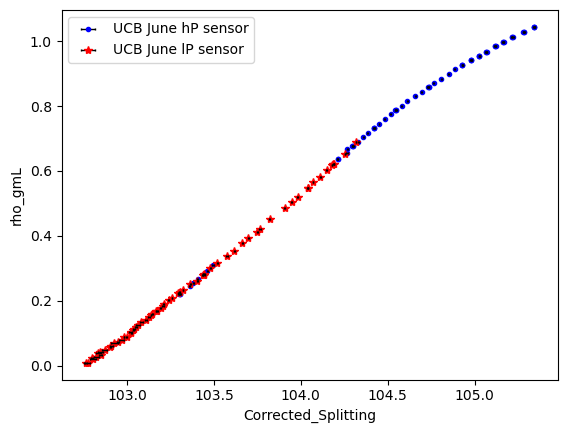

In [14]:
# Filter out bad ones from the high pressure sensor and concatenate the frames 
test=mpjune_hpsens.drop(columns=['Offset','filename_merge'])
hpsens_june=pd.concat([test,hpjune])

cali_pts_hpsens=hpsens_june[~(hpsens_june['rho_gmL'].between(0.325,0.63))]

# Filter out bad ones from low pressure sensor and concat frames
lpsens_june=lpmpjune.copy()
cali_pts_lpsens=lpsens_june[~(lpsens_june['rho_gmL'].between(0.46,0.48))]
cali_pts_lpsens = cali_pts_lpsens.replace([np.inf, -np.inf], np.nan)

cali_pts_lpsens = cali_pts_lpsens.dropna(subset=['rho_gmL'])

fig,ax=plt.subplots()

x='Corrected_Splitting'
y='rho_gmL'
y_pw='rho_gmL'


ax.errorbar(x=cali_pts_hpsens[x],y=cali_pts_hpsens[y], xerr=cali_pts_hpsens['Corr_Split_1σ_val'], fmt='.',
             color='blue',mfc='blue', ecolor='black', elinewidth=1,capsize=1,barsabove=True,zorder=2,
           label='UCB June hP sensor')


ax.errorbar(x=cali_pts_lpsens[x],y=cali_pts_lpsens[y_pw], xerr=cali_pts_lpsens['Corr_Split_1σ_val'], fmt='*',
             color='red',mfc='red', ecolor='black', elinewidth=1,capsize=1,barsabove=True,zorder=2,
           label='UCB June lP sensor')

ax.set_xlabel(x)
ax.set_ylabel(y)

plt.legend()


plt.show()

Text(0, 0.5, 'HB Area/Diad Area')

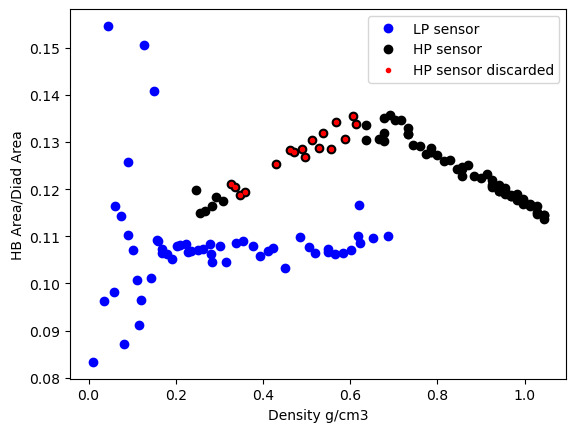

In [15]:
lpmpjune_c=pf.calculate_HB_Diad_area_ratio(df=lpmpjune)
hpsens_june_c=pf.calculate_HB_Diad_area_ratio(df=hpsens_june)
discard=(hpsens_june_c['rho_gmL'].between(0.325,0.63))
plt.plot(lpmpjune_c['rho_gmL'], lpmpjune_c['HB_Diad_Ratio'], 'ob', label='LP sensor')
plt.plot(hpsens_june_c['rho_gmL'], hpsens_june_c['HB_Diad_Ratio'], 'ok', label='HP sensor')
plt.plot(hpsens_june_c['rho_gmL'].loc[discard], hpsens_june_c['HB_Diad_Ratio'].loc[discard], '.r', label='HP sensor discarded')
plt.legend()
plt.xlabel('Density g/cm3')
plt.ylabel('HB Area/Diad Area')

Text(0, 0.5, 'rho_gmL')

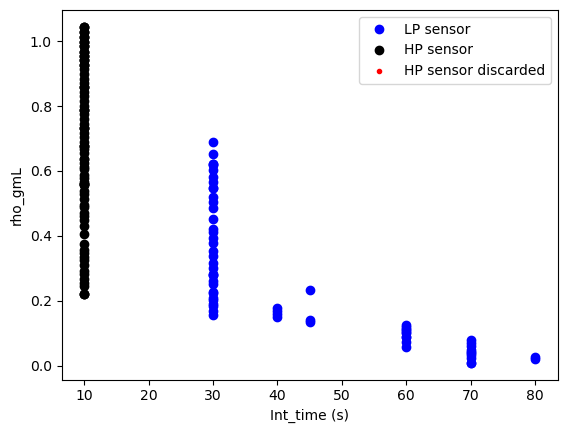

In [16]:
#plt.plot(combo_c['Int_time (s)'], combo_c['HB_Total_Ratio'], 'ok')

x='Int_time (s)'
y='rho_gmL'
lpmpjune_c=pf.calculate_HB_Diad_area_ratio(df=lpmpjune)
hpsens_june_c=pf.calculate_HB_Diad_area_ratio(df=hpsens_june)
discard=(hpsens_june_c[x].between(0.325,0.63))
plt.plot(lpmpjune_c[x], lpmpjune_c[y], 'ob', label='LP sensor')
plt.plot(hpsens_june_c[x], hpsens_june_c[y], 'ok', label='HP sensor')
plt.plot(hpsens_june_c[x].loc[discard], hpsens_june_c[y].loc[discard], '.r', label='HP sensor discarded')
plt.legend()
plt.xlabel(x)
plt.ylabel(y)

Text(0, 0.5, 'HB_Diad_Ratio')

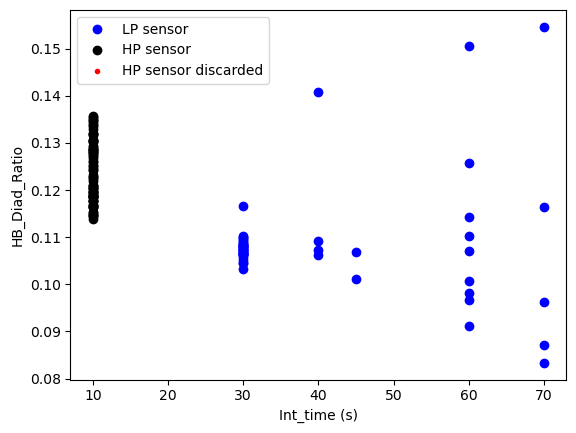

In [17]:
#plt.plot(combo_c['Int_time (s)'], combo_c['HB_Total_Ratio'], 'ok')

x='Int_time (s)'
y='HB_Diad_Ratio'
lpmpjune_c=pf.calculate_HB_Diad_area_ratio(df=lpmpjune)
hpsens_june_c=pf.calculate_HB_Diad_area_ratio(df=hpsens_june)
discard=(hpsens_june_c[x].between(0.325,0.63))
plt.plot(lpmpjune_c[x], lpmpjune_c[y], 'ob', label='LP sensor')
plt.plot(hpsens_june_c[x], hpsens_june_c[y], 'ok', label='HP sensor')
plt.plot(hpsens_june_c[x].loc[discard], hpsens_june_c[y].loc[discard], '.r', label='HP sensor discarded')
plt.legend()
plt.xlabel(x)
plt.ylabel(y)

Text(0, 0.5, 'HB Area/Diad Area')

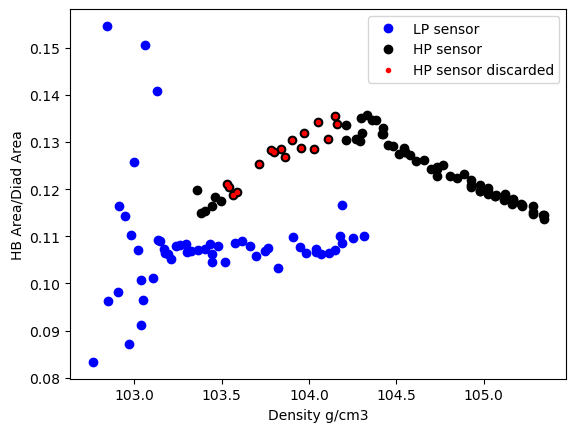

In [18]:
lpmpjune_c=pf.calculate_HB_Diad_area_ratio(df=lpmpjune)
hpsens_june_c=pf.calculate_HB_Diad_area_ratio(df=hpsens_june)
discard=(hpsens_june_c['rho_gmL'].between(0.325,0.63))
plt.plot(lpmpjune_c['Corrected_Splitting'], lpmpjune_c['HB_Diad_Ratio'], 'ob', label='LP sensor')
plt.plot(hpsens_june_c['Corrected_Splitting'], hpsens_june_c['HB_Diad_Ratio'], 'ok', label='HP sensor')
plt.plot(hpsens_june_c['Corrected_Splitting'].loc[discard], hpsens_june_c['HB_Diad_Ratio'].loc[discard], '.r', label='HP sensor discarded')
plt.legend()
plt.xlabel('Density g/cm3')
plt.ylabel('HB Area/Diad Area')

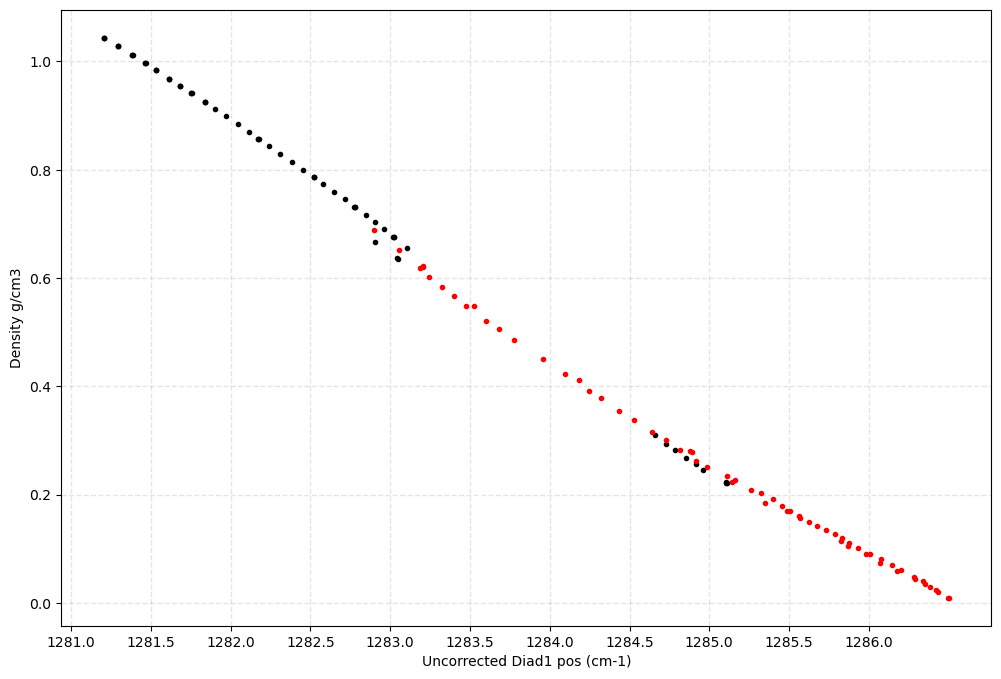

In [19]:
fig, (ax1) = plt.subplots(1, 1, figsize = (12,8))
ax1.plot(hpsens_june_c['Diad1_Combofit_Cent'].loc[~discard],hpsens_june_c['rho_gmL'].loc[~discard],  '.k' )
ax1.plot(lpmpjune_c['Diad1_Combofit_Cent'], lpmpjune_c['rho_gmL'], '.r')
ax1.set_ylabel('Density g/cm3')
ax1.set_xlabel('Uncorrected Diad1 pos (cm-1)')
ax1.grid(color = 'k', linestyle = '--', linewidth = 1, alpha = 0.1)
ax1.set_xticks([1281, 1281.5, 1282, 1282.5, 1283, 1283.5, 1284, 1284.5, 1285, 1285.5, 1286])
fig.savefig('Diad1pos.png')

In [20]:
hpsens_june_c.columns

Index(['Label', 'P_kbar', 'T_K', 'CO2_dens_gcm3', 'P_Mpa_target', 'P_manual',
       'T0_manual', 'T1_manual', 'T2_manual', 'T3_manual', 'T4_manual',
       'Corrected_Splitting', 'Corr_Split+1σ', 'Corr_Split-1σ',
       'Corr_Split_1σ_val', 'filename_x', 'Splitting', 'Split_err_abs',
       'Split_err_quadrature', 'Diad1_Combofit_Cent', 'Diad1_cent_err',
       'Diad1_Combofit_Height', 'Diad1_Voigt_Cent', 'Diad1_Voigt_Area',
       'Diad1_Voigt_Sigma', 'Diad1_Residual', 'Diad1_Prop_Lor', 'Diad1_fwhm',
       'Diad1_refit', 'Diad2_Combofit_Cent', 'Diad2_cent_err',
       'Diad2_Combofit_Height', 'Diad2_Voigt_Cent', 'Diad2_Voigt_Area',
       'Diad2_Voigt_Sigma', 'Diad2_Voigt_Gamma', 'Diad2_Residual',
       'Diad2_Prop_Lor', 'Diad2_fwhm', 'Diad2_refit', 'HB1_Cent', 'HB1_Area',
       'HB1_Sigma', 'HB2_Cent', 'HB2_Area', 'HB2_Sigma', 'C13_Cent',
       'C13_Area', 'C13_Sigma', 'Diad2_Gauss_Cent', 'Diad2_Gauss_Area',
       'Diad2_Gauss_Sigma', 'Diad1_Gauss_Cent', 'Diad1_Gauss_Area',
   

Text(0, 0.5, 'HB Area/Total Area')

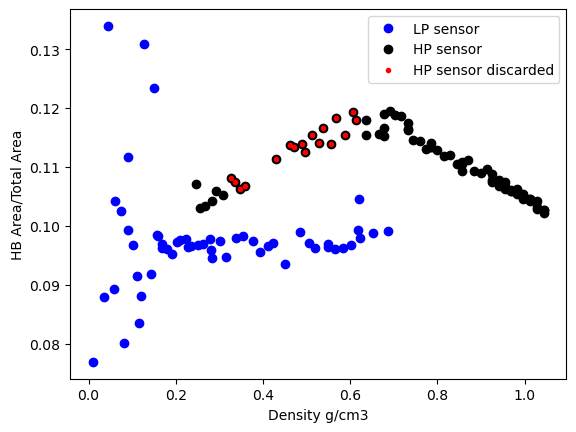

In [21]:
lpmpjune_c=pf.calculate_HB_Diad_area_ratio(df=lpmpjune)
hpsens_june_c=pf.calculate_HB_Diad_area_ratio(df=hpsens_june)
discard=(hpsens_june_c['rho_gmL'].between(0.325,0.63))
plt.plot(lpmpjune_c['rho_gmL'], lpmpjune_c['HB_Total_Ratio'], 'ob', label='LP sensor')
plt.plot(hpsens_june_c['rho_gmL'], hpsens_june_c['HB_Total_Ratio'], 'ok', label='HP sensor')
plt.plot(hpsens_june_c['rho_gmL'].loc[discard], hpsens_june_c['HB_Total_Ratio'].loc[discard], '.r', label='HP sensor discarded')
plt.legend()
plt.xlabel('Density g/cm3')
plt.ylabel('HB Area/Total Area')

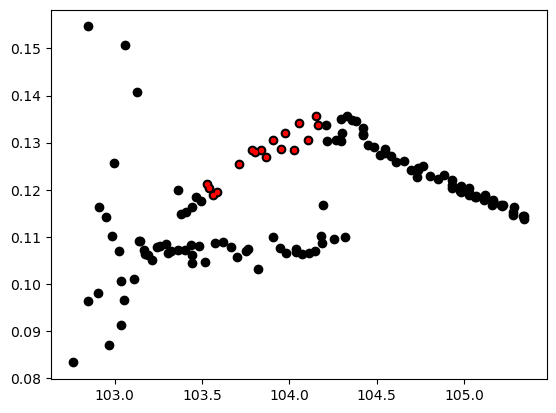

In [22]:
lpmpjune_c=pf.calculate_HB_Diad_area_ratio(df=lpmpjune)
hpsens_june_c=pf.calculate_HB_Diad_area_ratio(df=hpsens_june)
discard=(hpsens_june_c['rho_gmL'].between(0.325,0.63))
plt.plot(lpmpjune_c['Corrected_Splitting'], lpmpjune_c['HB_Diad_Ratio'], 'ok')
plt.plot(hpsens_june_c['Corrected_Splitting'], hpsens_june_c['HB_Diad_Ratio'], 'ok')
plt.plot(hpsens_june_c['Corrected_Splitting'].loc[discard], hpsens_june_c['HB_Diad_Ratio'].loc[discard], '.r')

In [23]:
cali_pts_hpsens['BSF_diad1']=cali_pts_hpsens['Diad1_fwhm']/cali_pts_hpsens['Diad1_Combofit_Height']
cali_pts_hpsens['BSF_diad2']=cali_pts_hpsens['Diad2_fwhm']/cali_pts_hpsens['Diad2_Combofit_Height']
cali_pts_lpsens['BSF_diad1']=cali_pts_lpsens['Diad1_fwhm']/cali_pts_lpsens['Diad1_Combofit_Height']
cali_pts_lpsens['BSF_diad2']=cali_pts_lpsens['Diad2_fwhm']/cali_pts_lpsens['Diad2_Combofit_Height']



C:\Users\penny\AppData\Local\Temp\ipykernel_35676\2745985068.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cali_pts_hpsens['BSF_diad1']=cali_pts_hpsens['Diad1_fwhm']/cali_pts_hpsens['Diad1_Combofit_Height']
C:\Users\penny\AppData\Local\Temp\ipykernel_35676\2745985068.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cali_pts_hpsens['BSF_diad2']=cali_pts_hpsens['Diad2_fwhm']/cali_pts_hpsens['Diad2_Combofit_Height']


Text(0, 0.5, 'Diad1 intesity')

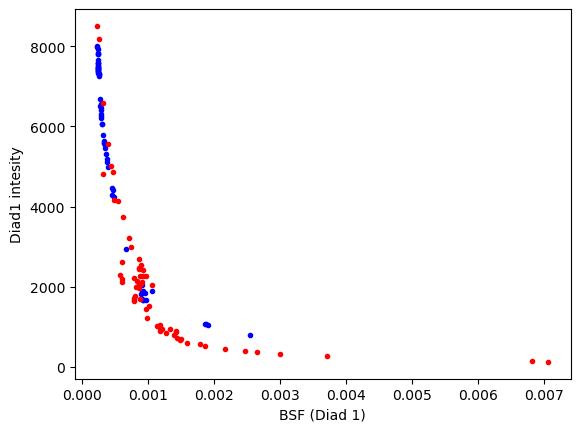

In [24]:
plt.plot(cali_pts_hpsens['BSF_diad1'], cali_pts_hpsens['Diad1_Combofit_Height'], '.b')
plt.plot(cali_pts_lpsens['BSF_diad1'], cali_pts_lpsens['Diad1_Combofit_Height'], '.r')
plt.xlabel('BSF (Diad 1)')
plt.ylabel('Diad1 intesity')

Text(0, 0.5, 'Diad1 intesity')

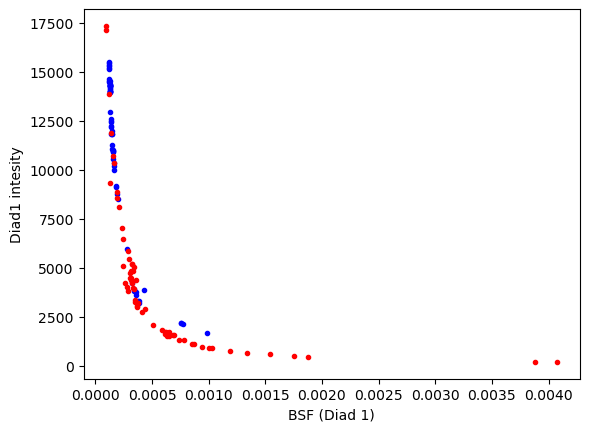

In [25]:
plt.plot(cali_pts_hpsens['BSF_diad2'], cali_pts_hpsens['Diad2_Combofit_Height'], '.b')
plt.plot(cali_pts_lpsens['BSF_diad2'], cali_pts_lpsens['Diad2_Combofit_Height'], '.r')
plt.xlabel('BSF (Diad 1)')
plt.ylabel('Diad1 intesity')

In [26]:
cali_pts_lpsens['sigma']=cali_pts_lpsens['Corrected_Splitting']-cali_pts_lpsens['Corr_Split+1σ']

Text(0, 0.5, 'Diad 2 peak fitting error')

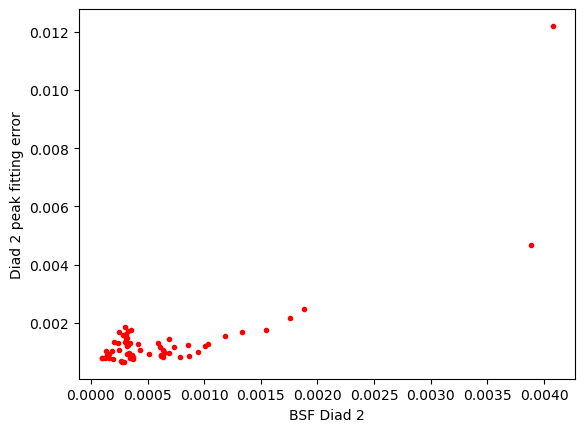

In [27]:
plt.plot(cali_pts_lpsens['BSF_diad2'], cali_pts_lpsens['Diad2_cent_err'], '.r', label='Diad2')
#plt.plot(cali_pts_lpsens['BSF_diad1'], cali_pts_lpsens['Diad1_cent_err'], '.b', label='Diad1')
plt.xlabel('BSF Diad 2')
plt.ylabel('Diad 2 peak fitting error')

## Merge the whole dataset for fitting

In [43]:
cali_pts_hpsens.columns

Index(['Label', 'P_kbar', 'T_K', 'CO2_dens_gcm3', 'P_Mpa_target', 'P_manual',
       'T0_manual', 'T1_manual', 'T2_manual', 'T3_manual', 'T4_manual',
       'Corrected_Splitting', 'Corr_Split+1σ', 'Corr_Split-1σ',
       'Corr_Split_1σ_val', 'filename_x', 'Splitting', 'Split_err_abs',
       'Split_err_quadrature', 'Diad1_Combofit_Cent', 'Diad1_cent_err',
       'Diad1_Combofit_Height', 'Diad1_Voigt_Cent', 'Diad1_Voigt_Area',
       'Diad1_Voigt_Sigma', 'Diad1_Residual', 'Diad1_Prop_Lor', 'Diad1_fwhm',
       'Diad1_refit', 'Diad2_Combofit_Cent', 'Diad2_cent_err',
       'Diad2_Combofit_Height', 'Diad2_Voigt_Cent', 'Diad2_Voigt_Area',
       'Diad2_Voigt_Sigma', 'Diad2_Voigt_Gamma', 'Diad2_Residual',
       'Diad2_Prop_Lor', 'Diad2_fwhm', 'Diad2_refit', 'HB1_Cent', 'HB1_Area',
       'HB1_Sigma', 'HB2_Cent', 'HB2_Area', 'HB2_Sigma', 'C13_Cent',
       'C13_Area', 'C13_Sigma', 'Diad2_Gauss_Cent', 'Diad2_Gauss_Area',
       'Diad2_Gauss_Sigma', 'Diad1_Gauss_Cent', 'Diad1_Gauss_Area',
   

In [44]:
y='CO2_dens_gcm3'
x='Corrected_Splitting'
full=pd.concat([pd.DataFrame(data={'Split':cali_pts_hpsens[x],'rho':cali_pts_hpsens[y],'spliterr':cali_pts_hpsens['Corr_Split_1σ_val']}),pd.DataFrame(data={'Split':cali_pts_lpsens[x],'rho':cali_pts_lpsens[y_pw],'spliterr':cali_pts_lpsens['Corr_Split_1σ_val']})])
full_sort=full.sort_values('rho')
# plt.scatter(full_sort['Split'],full_sort['rho'])

In [33]:
full_sort.columns

Index(['Split', 'rho', 'spliterr'], dtype='object')

## Fit the calibration lines 

In [47]:
full_sort['dens_err']=0

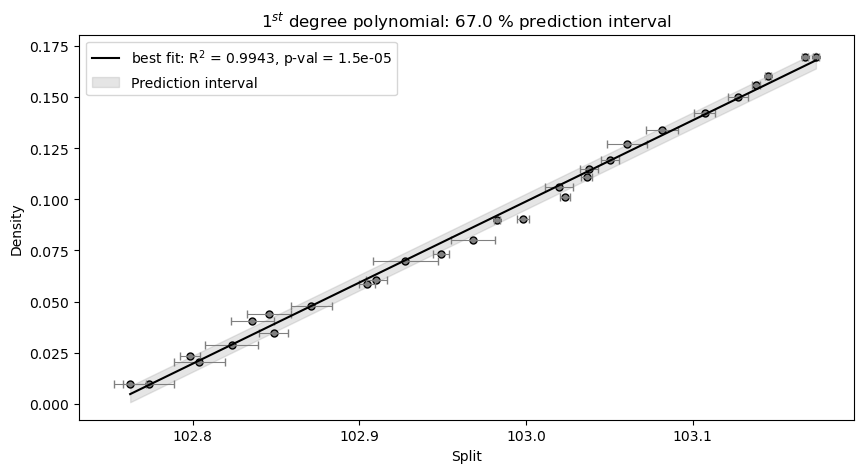

In [48]:
CI=0.67
pf.plot_and_save_CO2cali_pickle(cali_data=full_sort, density_range='Low',N_poly=1, CI=CI, std_error=True,save_fig=True,
                                
                                 split_error='spliterr')


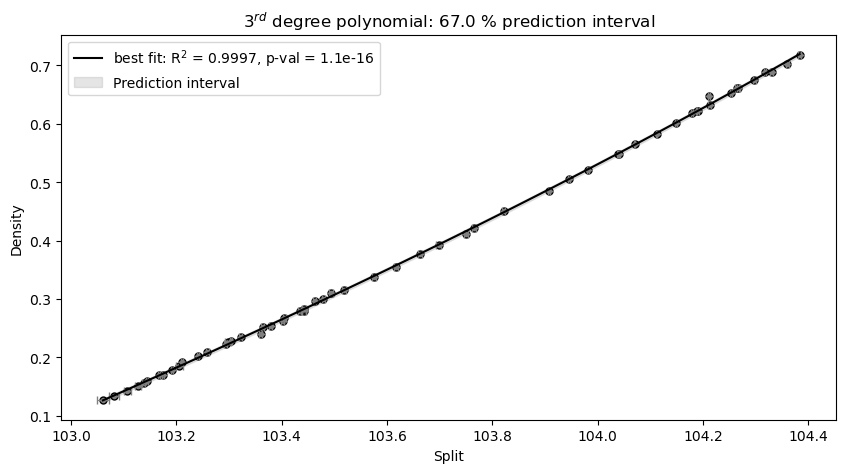

In [50]:
pf.plot_and_save_CO2cali_pickle(cali_data=full_sort, density_range='Medium',N_poly=3, CI=CI, std_error=True,save_fig=True,
                                split_error='spliterr')


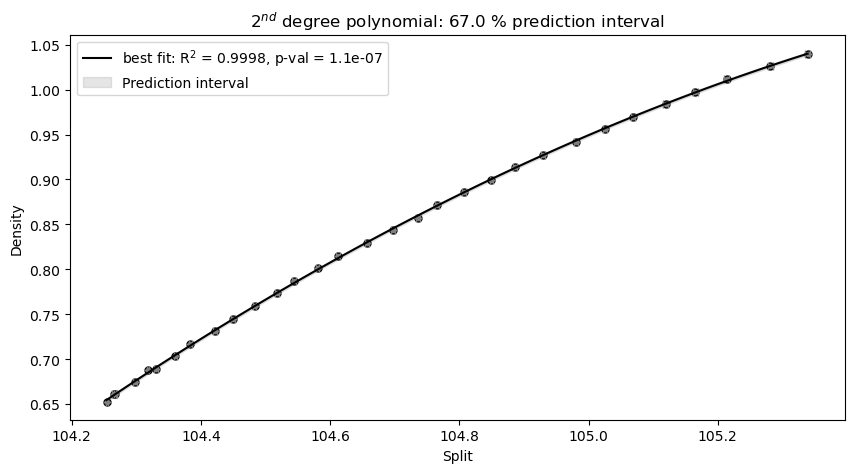

In [51]:
pf.plot_and_save_CO2cali_pickle(cali_data=full_sort, density_range='High',N_poly=2, CI=CI, std_error=True,save_fig=True,
                                split_error='spliterr')